# Сегмантация договоров при помощи: **Linear Conv1D нейросеть**, **PSPnet**, **UNET**



# Сегментация текстов

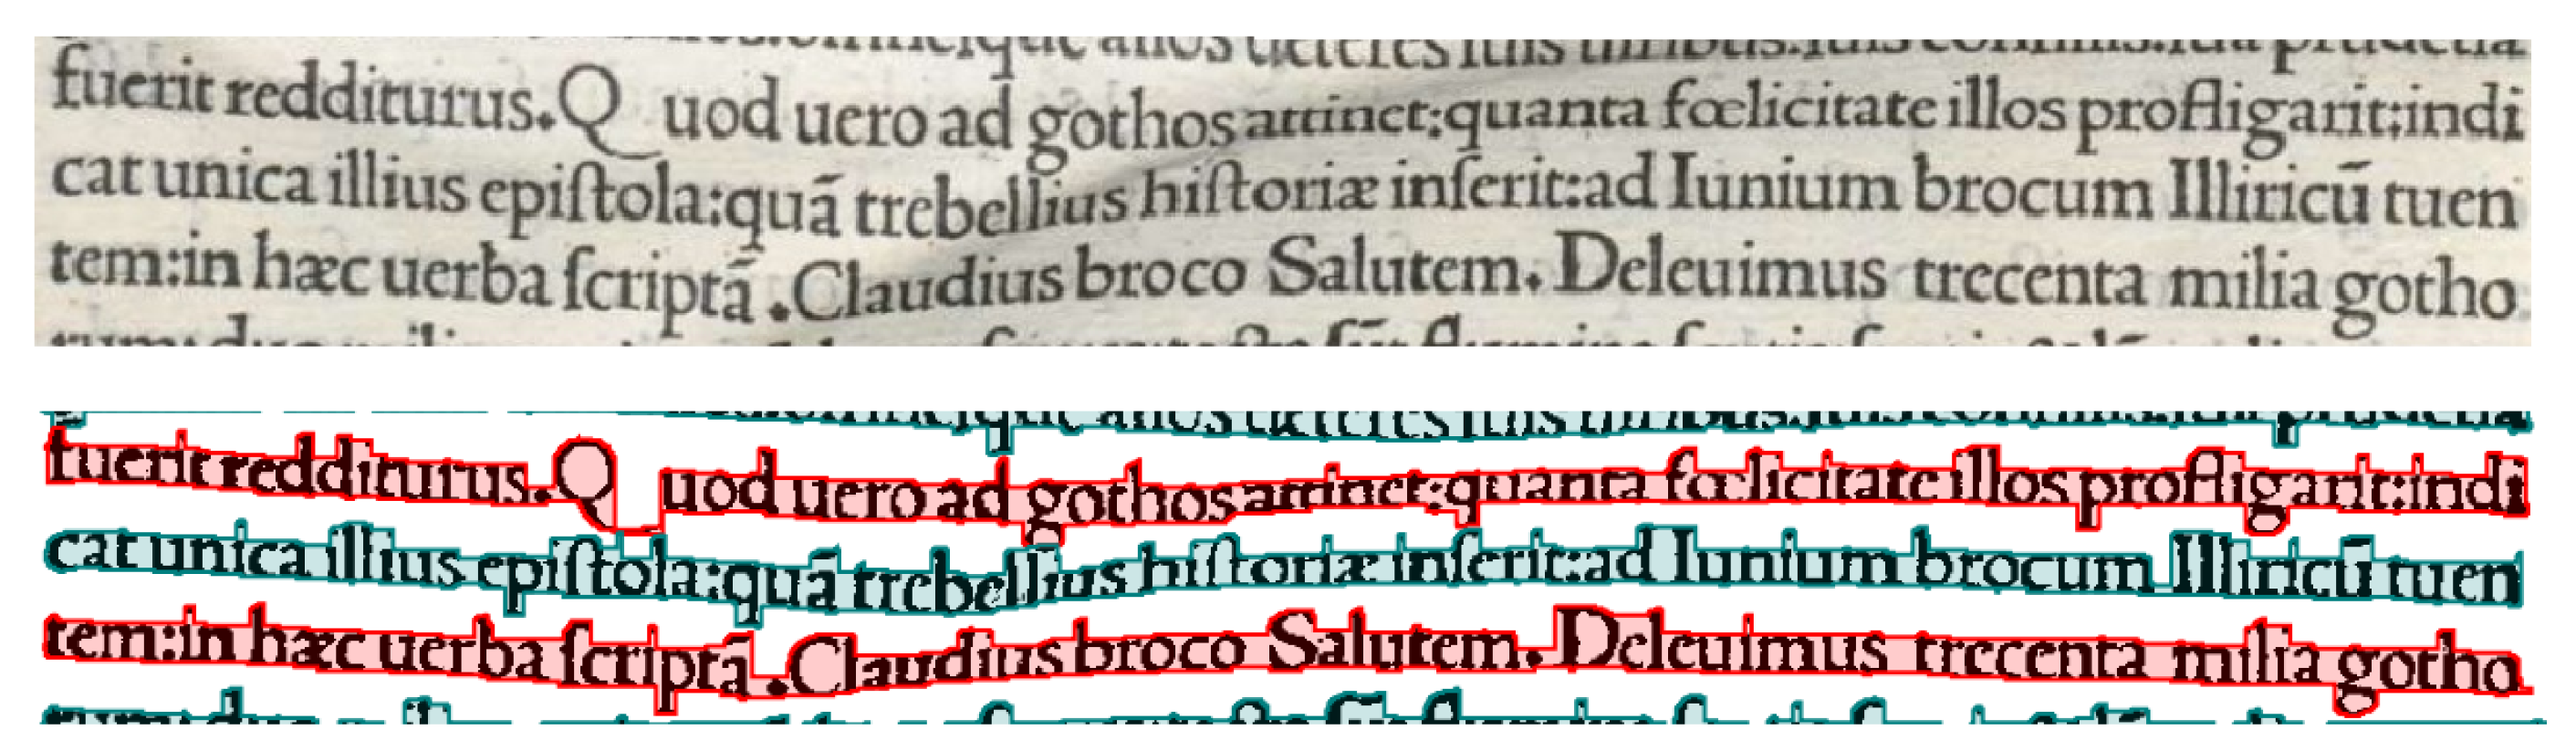

# Импорт библиотек

https://youtu.be/wdi8HYhgGj0?t=97

In [ ]:
!pip install -q pymorphy2 # установка лемматизатора pymorphy2

In [ ]:
!pip install tensorflow==2.3 # устанавливаем версию tf 2.3 и делаем restart runtime

In [ ]:
import numpy as np # Библиотека для работы с массивами данных
from tensorflow.keras.models import Model, load_model # Импортируем Model, load_model - метод, что загружает предобученную сеть
import re # Имортируем чтобы работать с строками
from tensorflow.keras.preprocessing.text import Tokenizer # Метод, который поволяет работать с текстами и конвертирует их в последовательности (индексов)
# Импорт слоёв нейронных сетей
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D, BatchNormalization, Dropout, Conv2DTranspose, Conv1DTranspose, Lambda
from tensorflow.keras import backend as K # Импортируем, чтобы высчитать dice_coef(ошибку)
from tensorflow.keras.optimizers import Adam, Adadelta # Импортируем оптимизаторы
from tensorflow.keras import utils # Импортируем для работы с категориальными данными
import tensorflow
from google.colab import files # Импорт для работы с файлами
import matplotlib.pyplot as plt # Импорт для отрисовывания графиков
from gensim.models import word2vec # Импортируем gensim
import os # Импортируем для работы с системными файлами
import pandas as pd # Импортируем для работы с Массивами данных(таблицами - Датафреймами)
import time # Имортируем, чтобы высчитать время работы каких-либо процессов
import nltk #Natural language toolkit - Инструментарий естественного языка
from nltk.stem import WordNetLemmatizer  # Импортируем для работы с леммами
import pymorphy2 # Импортируем для работы с леммами

nltk.download('wordnet') # Скачиваем сетку слов для лемматизации

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Функции для работы с текстами

https://youtu.be/wdi8HYhgGj0?t=126

Превращаем договоры в листы слов

# **Лист тегов и их значений**
https://youtu.be/wdi8HYhgGj0?t=48
**`<s1>`** - Условия

**`<s2>`** - Запреты

**`<s3>`** - Цена

**`<s4>`** - Условия (относительно дат)

**`<s5>`** - Штрафы

**`<s6>`** - Адреса и местоположения


In [ ]:
# Считываем текст из файла и удаляем пунктуационные знаки препинания и еще дополнительные ненужные нам знаки
def readText(fileName):
  f = open(fileName, 'r') # Открываем наш файл и считываем наши данные
  text = f.read() # Помещаем наш текст в переменную
  # Определяем, какие знаки будут удалены
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";",'•','%']

  for dS in delSymbols: # Каждый знак из нашего списка будет удалён из списка
    text = text.replace(dS, " ") # Удаляем знак, посредством замены этого знака на пробел

  # Выискиваем дополнительные знаки в текстах посредством паттернов и определяем на что их заменять
  text = re.sub("[.]", " ", text)
  text = re.sub(":", " ", text)
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)

  # split  метод разделит текст на последовательность слов при помощи пробелов
  # (а их может быть в одном месте очень много после наших удалений знаков), которые будет являться разделителями.
  # Используя join метод, мы обратно соберём последовательности слов в текст
  text = ' '.join(text.split()) 

  text = text.lower() # Конвертируем текст к нижнему регистру
  return text # Возвращаем текст

# Конвертируем исходный текст в лист слов с начальной формой 
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer() # Инициализируем инструмент для работы с морфемами и более
  words = text.split(' ') #  Разделяем текст по средством пробелов
  docs = [morph.parse(word)[0].normal_form for word in words] # Превращаем каждое слово в элемент списка
  return docs # Возвращаем полученный документ

# Read the data

https://youtu.be/wdi8HYhgGj0?t=330



In [ ]:
directory = '/content/drive/My Drive/Базы/Договоры 432/' # Путь к папке с договорами
os.listdir(directory)[250:255] # Выводим на экран название 5 договоров

['dogovor-zaloga-privatizirovannoy-kvartiri.txt',
 'dogovor-zaloga-s-peredachej-predmeta-zaloga-zalogoderzhatelyu.txt',
 'dogovor-zaloga-nedvizhimosti.txt',
 'dogovor-zaloga-imuschestvennih-prav.txt',
 'dogovor-zaloga-imuschestva-kvartiri.txt']

In [ ]:
print('Всего', len(os.listdir(directory)), 'договора')

Всего 432 договора


In [ ]:
curTime = time.time() # Запоминаем текущее время
agreements = [] # Лист, что будет хранить все наши договоры
for filename in os.listdir(directory): # Проходимся по каждому договору
  txt = readText(directory + filename) # Считываем текст в договоре
  if txt != '': # Если договор не пустой
    agreements.append(readText(directory + filename)) # Превращаем файл в текст и добавляем его в agreements
print('Загрузка файла заняла: ', round(time.time() - curTime, 2), 'с.')

Загрузка файла заняла:  0.96 с.


In [ ]:
n = 3
print(os.listdir(directory)[n]) # Выводим названия n-ого договора
agreements[n]                   # Текст n-ого договора

2 (5).txt


'договор пожизненного содержания с иждивением с предоставлением иного жилого помещения для проживания взамен передаваемого г г гражданин паспорт серия номер выдан проживающий по адресу именуемый в дальнейшем получатель ренты с одной стороны и гражданин паспорт серия номер выдан проживающий по адресу именуемый в дальнейшем плательщик ренты с другой стороны именуемые в дальнейшем стороны заключили настоящий договор в дальнейшем договор о нижеследующем 1 предмет договора 1 1 <s1> получатель ренты передает плательщику ренты в собственность квартиру <s6> расположенную по адресу </s6> именуемую в дальнейшем передаваемое помещение а плательщик ренты в обмен на полученное помещение предоставляет получателю ренты квартиру комнату для проживания и <s3> обязуется осуществлять пожизненное содержание с иждивением получателя ренты под содержанием с иждивением в настоящем договоре понимается обеспечение потребностей получателя ренты в жилище питании и одежде уход за ним оплата ритуальных услуг </s1> 

In [ ]:
docs_full = [] # Лист будет содержать все договоры как списки документов
curTime = time.time() # Запоминаем текущее время
for i in range(len(agreements)): # Проходимся по каждому договору
  docs_full.append(text2Words(agreements[i])) # Превращаем договор в лист слов и добавляем его в docs_full
print('Превращение заняло: ', round(time.time() - curTime, 2), 's.')

Превращение заняло:  154.98 s.


In [ ]:
print(len(docs_full)) # Выводим число записей в наборе данных 

# Выбираем итоговое количество данных для обучающей/проверочной и тестовой выборках
docs = docs_full[0:-10]
docsToTest = docs_full[-10:]

422


In [ ]:
print('Число текстов в для тестовой проверки в конце ноутбука:', len(docsToTest)) 
print('Число договоров для обучающей и проверочной выборках:',len(docs)) 
print('Число слов в первом договоре:', len(docs[10]))

Число текстов в для тестовой проверки в конце ноутбука: 10
Число договоров для обучающей и проверочной выборках: 412
Число слов в первом договоре: 502


In [ ]:
print('Пример текста обычного:')
print(agreements[4][:62], '\n')
print('Тот же текст, но представленный ввиде лемм:')
print(docs[4][:10])

Пример текста обычного:
договор бартера г г в лице действующего на основании именуемый 

Тот же текст, но представленный ввиде лемм:
['договор', 'бартер', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать']


# Превращение текстов в последовтельность индексов: создание xTrain
https://youtu.be/wdi8HYhgGj0?t=594

In [ ]:
# lower=True - приводит к нижнему регистру все слова
# char_level=False - говорит токенайзеру не инициализировать отдельно каждую букву как токен  
tokenizer = Tokenizer(lower=True, filters = '', char_level=False)

tokenizer.fit_on_texts(docs_full) # Скармливаем тексты токенайзеру
clean_voc = {}                    # Создаем пустой словарь

for item in tokenizer.word_index.items(): # Превращаем лист в словарь
  clean_voc[item[0]] = item[1]            # Мы меняем местами элеметны кортежа

In [ ]:
print('Словарь все слов по их частотноти:') 
print(clean_voc, '\n')
print('Длина словаря:', len(clean_voc))

tag = '<s1>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

Словарь все слов по их частотноти:
{'в': 1, 'договор': 2, 'и': 3, '2': 4, '1': 5, 'по': 6, 'сторона': 7, 'с': 8, 'настоящий': 9, 'на': 10, '3': 11, '<s1>': 12, '</s1>': 13, 'не': 14, '4': 15, 'или': 16, 'за': 17, 'он': 18, 'случай': 19, 'о': 20, '5': 21, '<s3>': 22, '</s3>': 23, 'право': 24, 'работа': 25, 'срок': 26, '<s4>': 27, '</s4>': 28, 'от': 29, 'при': 30, 'они': 31, '6': 32, 'другой': 33, 'быть': 34, 'лицо': 35, 'имущество': 36, 'день': 37, 'действовать': 38, 'арендатор': 39, 'условие': 40, 'для': 41, '7': 42, 'к': 43, 'если': 44, 'п': 45, 'дальнейший': 46, 'работник': 47, 'который': 48, 'а': 49, 'обязательство': 50, 'страховой': 51, 'законодательство': 52, 'порядок': 53, 'сумма': 54, 'размер': 55, 'действие': 56, 'арендодатель': 57, 'свой': 58, 'счёт': 59, 'соответствие': 60, 'указанный': 61, 'именовать': 62, 'мочь': 63, 'из': 64, 'основание': 65, 'обязанность': 66, 'обязать': 67, 'исполнение': 68, 'один': 69, 'страховщик': 70, 'страхователь': 71, 'иной': 72, 'год': 73, 'до': 7

In [ ]:
# Превращает текст в последовательность индексов согласно словарю частотности
tok_agreem = tokenizer.texts_to_sequences(docs) # Обучающий выборка в последовтельность индексов

print("Взгляните на фрагмент обучающей выборки:")
print("Исходный текст:              ", docs[4][:20])
print("Тот же текст, но как последовательность индексов: ", tok_agreem[4][:20], '\n')

Взгляните на фрагмент обучающей выборки:
Исходный текст:               ['договор', 'бартер', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'сторона', '1', 'с', 'один', 'сторона', 'и', 'в', 'лицо']
Тот же текст, но как последовательность индексов:  [2, 4233, 76, 76, 1, 35, 38, 10, 65, 62, 1, 46, 7, 5, 8, 69, 7, 3, 1, 35] 



# Создание yTrain

https://youtu.be/wdi8HYhgGj0?t=695

Каждый индекс (слово) из договора будет соответсвовать вектору, чьи элементы соотвествуют категориям тегов

In [ ]:
#  Собираем лист индексов и их мультилейбл класссификации
def getXYSamples(tok_agreem, tags_index):
  tags01 = [] # лист тегов
  indices = [] # лист индексов
 
  for agreement in tok_agreem: # Проходимся по каждому договору-листу
    tag_place = [0, 0, 0, 0, 0, 0] # создаём вектор [0,0,0,0,0,0] 
    for ex in agreement: # Проходимся по каждому слову из договора
        if ex in tags_index: # Проверяем, если индекс слова соотвествует индексу одного из тегов
          place = np.argwhere(tags_index==ex) # Запоминаем позицию тега в этом листе тегов
          if len(place)!=0: # Проверяем, если тек в самом деле есть
            if place[0][0]<6: # Первые 6 тегов - открывающие теги
              tag_place[place[0][0]] = 1    # устанавливаем значение 1
            else: 
              tag_place[place[0][0] - 6] = 0  # Все остальные теги закрывающие, так что мы меняем в соответсвующем месте в векторе на 0
        else:          
          tags01.append(tag_place.copy()) # Добавляем в наш лист тегов новые вектора мульти-лейбл классификации. 
                                          # В конце концов у нас будет большой лист всех вектор-тегов
          indices.append(ex) # Добавляем индекс-слова в лист индексов

  return indices, tags01

# Получаем лист слов из листа индексов
def reverseIndex(clean_voc, x):
  reverse_word_map = dict(map(reversed, clean_voc.items())) #  Берёт ключ и значение из словаря и меняет их местами
  docs = [reverse_word_map.get(letter) for letter in x] # Положим их в лист
  return docs # Возвращает текст

In [ ]:
#<s1> - Условия договора
#<s2> - Запреты
#<s3> - Стоимость
#<s4> - Условия (относительно дат)
#<s5> - Штрафы
#<s6> - Адреса и местоположения

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)] # Лист открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)] # Лист закрывающих тегов
tags_index.extend(closetags) # конкатенируем все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # Получаем инексы всех тегов из словря частотности
print('Индексы всех тегов:', tags_index)

Индексы всех тегов: [ 12 341  22  27 117 278  13 352  23  28 118 273]


In [ ]:
curTime = time.time()
xData, yData = getXYSamples(tok_agreem,tags_index) # Получаем теги и создаём листы с ними
decoded_text = reverseIndex(clean_voc, xData) # Чтобы создать лист для эмбеддинга, нам нужно превратить лист индексов обратно в лист слов
print('Превращение заняло: ', round(time.time() - curTime, 2), 'с.')

Превращение заняло:  2.52 с.


In [ ]:
print('длина xData:', len(xData))
print('длина yData:', len(yData))

print('Посмотрим на исходные слова: ', docs[0][50:80])
print('Сдекодированые слова:', decoded_text[50:80])
print('Часть xData:     ', xData[50:80])
print('Часть yData:     ', yData[50:80])

длина xData: 408682
длина yData: 408682
Посмотрим на исходные слова:  ['1', 'предмет', 'договор', '1', '1', '<s1>', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '</s1>', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по']
Сдекодированые слова: ['1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор']
Часть xData:      [5, 112, 2, 5, 5, 6, 9, 2, 224, 115, 918, 319, 125, 18, 250, 3, 546, 244, 319, 1, 396, 5, 4, 250, 304, 10, 162, 6, 9, 2]
Часть yData:      [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0,

# Разделение выборки на окна

https://youtu.be/wdi8HYhgGj0?t=1310

In [ ]:
# Создание выборки из индексов
def getSetFromIndices(wordIndices, xLen, step): 
  xBatch = [] # Лист, хранящий фрагменты текста
  wordsLen = len(wordIndices) # получаем длину текста
  index = 0 #  стартовый индекс
  
  while (index + xLen <= wordsLen): # Пока сумма индекса и окна меньше или равно чем число слов в выборке
    xBatch.append(wordIndices[index:index+xLen]) # Добавляем X в лист, что содержит наши фрагменты(окна) текста
    index += step # Смещаем наше индекс на наш шаг(step)

  return xBatch #  Лист фрагментов текста

In [ ]:
xLen = 256 # Длина каждого окна
step = 30 # шаг 
embeddingSize = 300 # Число измерений вектор-пространства для каждого нашего слова 

In [ ]:
#  Генерируем выборки с параметрами наших окон
xTrain = getSetFromIndices(decoded_text, xLen, step) # Последовательность индексов с окном xLen слов
yTrain = getSetFromIndices(yData, xLen, step) # Последовательность индексов с окном xLen от тегов

In [ ]:
print('Длина xTrain:', len(xTrain))
print('Длина yTrain:', len(yTrain))
print('Длина примера из xTrain:',len(xTrain[0]))
print('Длина примера из yTrain:',len(yTrain[0]), '\n')
print('Пример xTrain', xTrain[0])
print('Пример yTrain', yTrain[0], '\n')

print('Первый пример xTrain:', xTrain[0][step-5:step+5])
print('Второй пример xTrain:', xTrain[1][:10])

Длина xTrain: 13615
Длина yTrain: 13615
Длина примера из xTrain: 256
Длина примера из yTrain: 256 

Пример xTrain ['договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'хранитель', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'поклажедатель', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор', 'следующий', 'вещь', 'далее', 'вещь', '1', '3', 'при', 'передача', 'вещь', 'по

In [ ]:
# Превращаем текст в последовательность индексов согласно словарю частотности
tok_agreemTest = tokenizer.texts_to_sequences(docsToTest) # Обучающий текст в индексы

print("Посмотрим на фрагмент тестового текста:")
print("Исходный текст:              ", docsToTest[4][:20])
print("Тот же текст, но как последовательность индексов: ", tok_agreemTest[4][:20], '\n')

xDataTest, yDataTest = getXYSamples(tok_agreemTest,tags_index) # Распознаём теги и создаём лист, что их хранят
decoded_text = reverseIndex(clean_voc, xDataTest) # Чтобы создать лист для эмбеддинга, нам нужно превратить лист индексов обратно в лист слов
print('Длина xDataTest:', len(xDataTest))
print('Длина yDataTest:', len(yDataTest))

print('Сдекодированные текст:', decoded_text[50:80])
print('Часть xDataTest:     ', xDataTest[50:80])
print('Часть yDataTest:     ', yDataTest[50:80])

xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300 # Число измерений вектор-пространства для каждого нашего слова 

# Генерируем выборки с определёнными параметрами
xTest = getSetFromIndices(decoded_text, xLen, step) # Последовательность индексов с окном Xlen слов
yTest = getSetFromIndices(yDataTest, xLen, step) # # Последовательность индексов с окном Xlen от тегов

print('Длина xTest:', len(xTest))
print('Длина yTest:', len(yTest))
print('Длина примера xTest:',len(xTest[0]))
print('Длина примера yTrain:',len(yTest[0]), '\n')
print('Пример xTest', xTest[0])
print('Пример yTest', yTest[0], '\n')

print('Первый пример xTest:', xTest[0][step-5:step+5])
print('Второй пример xTest:', xTest[1][:10])

Посмотрим на фрагмент тестового текста:
Исходный текст:               ['трудовой', 'контракт', 'с', 'специалист', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'работодатель', 'с', 'один', 'сторона', 'и', 'гражданин']
Тот же текст, но как последовательность индексов:  [79, 187, 8, 897, 76, 76, 1, 35, 38, 10, 65, 62, 1, 46, 129, 8, 69, 7, 3, 265] 

Длина xDataTest: 12768
Длина yDataTest: 12768
Сдекодированные текст: ['1', 'предмет', 'договор', '1', '1', 'работник', 'приниматься', 'на', 'работа', 'на', 'предприятие', 'на', 'должность', 'руководитель', 'служба', 'реклама', 'и', 'маркетинг', 'для', 'выполнение', 'трудовой', 'обязанность', 'связанный', 'с', 'руководство', 'указанный', 'служба', 'планирование', 'и', 'стимулирование']
Часть xDataTest:      [5, 112, 2, 5, 5, 47, 958, 10, 25, 10, 228, 10, 495, 675, 640, 1157, 3, 1899, 41, 96, 79, 66, 286, 8, 889, 61, 640, 2325, 3, 3563]
Часть yDataTest:      [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0,

# Функции создания моделей
https://youtu.be/wdi8HYhgGj0?t=1574

## Функция, что считает ошибку
https://youtu.be/wdi8HYhgGj0?t=1566

In [ ]:
# Функция нужна для точности
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

## **Conv1D**

https://youtu.be/wdi8HYhgGj0?t=1635

In [ ]:
# Функция, что создаёт линейную свёрточную сеть
def create_Conv1d(xLen, embeddingSize): 
  text_input_layer = Input((xLen,embeddingSize)) 
  text_layer = Conv1D(16, 3, padding='same',activation='relu')(text_input_layer)
  text_layer = Conv1D(16, 3, padding='same',activation='relu')(text_layer)
  text_layer = Conv1D(16, 3,padding='same', activation='relu')(text_layer) 
  text_layer = Conv1D(GENSIMtrainY.shape[-1], 3, padding='same',activation='sigmoid')(text_layer)
  model = Model(text_input_layer, text_layer)
  model.compile(optimizer=Adadelta(),
                    loss='categorical_crossentropy',
                    metrics=[dice_coef])
  return model

## **PSPnet**
https://youtu.be/wdi8HYhgGj0?t=1697

In [ ]:
# Функция по созданию сети PSPnet
def create_PSPNet(conv_size = 64, num_classes = 6, input_shape = (30, 300)):
    img_input = Input(input_shape)

    # Блок 1
    x = Conv1D(conv_size, 3, padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(conv_size, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_mp_2 = MaxPooling1D(2)(x)
    x_mp_4 = MaxPooling1D(4)(x)
    x_mp_8 = MaxPooling1D(8)(x)
    x_mp_16 = MaxPooling1D(16)(x)
    x_mp_32 = MaxPooling1D(32)(x)

    x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
    x_mp_2 = Dropout(0.5)(x_mp_2)

    x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
    x_mp_4 = Dropout(0.5)(x_mp_4)

    x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
    x_mp_8 = Dropout(0.5)(x_mp_8)

    x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
    x_mp_16 = Dropout(0.5)(x_mp_16)

    x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
    x_mp_32 = Dropout(0.5)(x_mp_32) 

    x_mp_2 = Conv1DTranspose(conv_size, 2, strides=2)(x_mp_2)
    x_mp_2 = Activation('relu')(x_mp_2)

    x_mp_4 = Conv1DTranspose(conv_size, 4, strides=4)(x_mp_4)
    x_mp_4 = Activation('relu')(x_mp_4)

    x_mp_8 = Conv1DTranspose(conv_size, 8, strides=8)(x_mp_8)
    x_mp_8 = Activation('relu')(x_mp_8)

    x_mp_16 = Conv1DTranspose(conv_size, 16, strides=16)(x_mp_16)
    x_mp_16 = Activation('relu')(x_mp_16)

    x_mp_32 = Conv1DTranspose(conv_size, 32, strides=32)(x_mp_32)
    x_mp_32 = Activation('relu')(x_mp_32)

    fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])    
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adadelta(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

##**UNET**
https://youtu.be/wdi8HYhgGj0?t=1769

In [ ]:
# Функция по созданию сети UNET
def create_unet(k = 1, num_classes = 6, input_shape= (30, 300)):
    img_input = Input(input_shape) 

    # Блок 1
    x = Conv1D(64 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(64 * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    # Блок 2
    x = MaxPooling1D()(block_1_out)
    x = Conv1D(128 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    # Блок 3
    x = MaxPooling1D()(block_2_out)
    x = Conv1D(256 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # Блок 4
    x = MaxPooling1D()(block_3_out)
    x = Conv1D(512 * k, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(256 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out]) 
    x = Conv1D(256 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(128 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(64 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

# Создание xTrain и  yTrain используя Word2Vec GENSIM

https://youtu.be/wdi8HYhgGj0?t=1830


In [ ]:
def pad_zeros(phrase, xLen = 256): # Функция для дополнением нулями
  while len(phrase) < xLen: # Пока сущестующий размер меньше чем требуемый 
    phrase.append([0] * embeddingSize) # Продолжаем добавлять элементы(нули) в фразу(zero-pad)  
  if len(phrase) > xLen: # В противном случае, если фраза больше чем  требуемый размер
    phrase = phrase[:xLen] # Берём только требуемое число элементов
  return phrase # Возвращаем обработанную фразу

# Создаём выборку
def getSets(model, senI, tagI):
  xVector = [] # Лист будет содержать ембеддинг представление на каждый индекс
  tmp = [] # Временный список
  for text in senI: # Проходимся по каждому лист-тексту
    tmp=[]
    for word in text: # Проходимся по кажому слову лист-текста
      try: # Если слово есть в модели (словарь не слишком мал), мы не получим ошибку
        tmp.append(model[word])
      except: # В противном случае пропустим слово
        pass

    xVector.append(pad_zeros(tmp, xLen))
  temp = np.array(xVector)
  return np.array(xVector, dtype = np.float32), np.array(tagI)

In [ ]:
# Подаём лист листов слов в word2vec для обучающей выборке
# size = embeddingSize - Размер ембеддинга
# window = 10 -  минимальное расстояния между эмбеддинг словами
# min_count = 1 - Игнорируем все слова с частотой меньше чем 1
# workers = 10 -  Число потоков на обучение эмбеддинга
# iter = 20 -  Число эпох на обучение эмбеддинга
# max_vocab_size = 1e5 -  Число слов в "словарном запасе" word2vec
curTime = time.time()

modelGENSIM = word2vec.Word2Vec(xTrain + xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10, max_vocab_size = 1e5)
print('Обучение GENSIM модели заняло: ', round(time.time() - curTime, 2), 'с.')

Обучение GENSIM модели заняло:  34.19 с.


In [ ]:
modelGENSIM['договор'] # Пример превращения слова в вектор при помощи GENSIM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 9.4301343e-01,  1.0432857e+00, -1.3224514e+00,  6.3923293e-01,
        1.7696300e-01,  3.9038066e-02,  8.9568073e-01, -3.0898182e-02,
        1.4784302e+00, -4.9798051e-01,  4.6925953e-01, -8.4910923e-01,
       -2.3411462e+00, -4.0021646e-01, -2.3608749e+00, -1.7219751e-01,
        4.6649581e-01,  7.7080196e-01, -1.4647540e+00,  3.3499472e+00,
       -4.7976863e-01, -1.9796157e+00,  4.7535334e+00,  9.5865583e-01,
        5.3411937e-01,  1.5352443e+00,  1.4814322e+00,  8.3887458e-01,
       -1.6854669e+00,  5.7438433e-01, -3.8445407e-01,  1.4761918e+00,
        1.2080005e+00,  6.8737692e-01,  8.1225824e-01,  4.6163964e-01,
        1.8946660e-01, -9.0518576e-01, -2.7382107e+00,  8.2400030e-01,
       -1.1225934e+00, -2.9283625e-01,  4.4744617e-01, -3.1724548e-01,
       -1.4833221e+00,  1.8464515e+00, -3.9699489e-01, -1.2524246e-01,
       -7.0416458e-02, -1.9953122e+00, -1.6035830e+00,  5.2345550e-01,
        1.9385753e+00,  5.7509094e-03,  1.1783278e+00, -2.0636151e+00,
      

In [ ]:
GENSIMtrainX, GENSIMtrainY = getSets(modelGENSIM, xTrain, yTrain)
GENSIMtestX, GENSIMtestY = getSets(modelGENSIM, xTest, yTest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [ ]:
print('Размерности xTrain:', GENSIMtrainX.shape)
print('Размерности yTrain:', GENSIMtrainY.shape)

Размерности xTrain: (13615, 256, 300)
Размерности yTrain: (13615, 256, 6)


# Train the networks
https://youtu.be/wdi8HYhgGj0?t=2099

## **Linear Conv1d network**

https://youtu.be/wdi8HYhgGj0?t=2103

In [ ]:
model_conv1d = create_Conv1d(xLen, embeddingSize) # Создаем модель
model_conv1d.summary() # Выводим саммери

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 300)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 16)           14416     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 16)           784       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 256, 16)           784       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 256, 6)            294       
Total params: 16,278
Trainable params: 16,278
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_conv1d.fit(GENSIMtrainX, GENSIMtrainY, epochs=5, batch_size=200, validation_data=(GENSIMtestX, GENSIMtestY)) # Обучаем модель на сверточной сети

Epoch 1/5
69/69 [==============================] - 4s 33ms/step - loss: 1.1629 - dice_coef: 0.2406 - val_loss: 1.1904 - val_dice_coef: 0.2217
Epoch 2/5
69/69 [==============================] - 2s 25ms/step - loss: 1.1495 - dice_coef: 0.2398 - val_loss: 1.1863 - val_dice_coef: 0.2222
Epoch 3/5
69/69 [==============================] - 2s 26ms/step - loss: 1.1524 - dice_coef: 0.2411 - val_loss: 1.1821 - val_dice_coef: 0.2228
Epoch 4/5
69/69 [==============================] - 2s 26ms/step - loss: 1.1349 - dice_coef: 0.2421 - val_loss: 1.1780 - val_dice_coef: 0.2235
Epoch 5/5
69/69 [==============================] - 2s 25ms/step - loss: 1.1582 - dice_coef: 0.2452 - val_loss: 1.1739 - val_dice_coef: 0.2241


## **PSPnet**
https://youtu.be/wdi8HYhgGj0?t=2141


### Стандартная архитектура

In [ ]:
model_b_PSPnet = create_PSPNet(input_shape=(xLen, embeddingSize))
model_b_PSPnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 256, 64)      57664       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 64)      256         conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 64)      0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
history = model_b_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=5, batch_size=64)

Epoch 1/5
213/213 [==============================] - 8s 26ms/step - loss: 2.0736 - dice_coef: 0.1695 - val_loss: 1.8411 - val_dice_coef: 0.1714
Epoch 2/5
213/213 [==============================] - 5s 22ms/step - loss: 2.0357 - dice_coef: 0.1730 - val_loss: 1.8401 - val_dice_coef: 0.1754
Epoch 3/5
213/213 [==============================] - 5s 22ms/step - loss: 1.9904 - dice_coef: 0.1764 - val_loss: 1.7976 - val_dice_coef: 0.1797
Epoch 4/5
213/213 [==============================] - 5s 22ms/step - loss: 1.9200 - dice_coef: 0.1803 - val_loss: 1.7485 - val_dice_coef: 0.1843
Epoch 5/5
213/213 [==============================] - 5s 22ms/step - loss: 1.9035 - dice_coef: 0.1861 - val_loss: 1.6980 - val_dice_coef: 0.1892


### 256 нейронов в свёрточном ядре

In [ ]:
model_b_PSPnet = create_PSPNet(conv_size = 256, input_shape=(xLen, embeddingSize))
model_b_PSPnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 256, 256)     230656      input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 256, 256)     1024        conv1d_14[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 256, 256)     0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

In [ ]:
history = model_b_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=5, batch_size=64)

Epoch 1/5
213/213 [==============================] - 18s 73ms/step - loss: 1.8186 - dice_coef: 0.1697 - val_loss: 1.5571 - val_dice_coef: 0.1770
Epoch 2/5
213/213 [==============================] - 14s 68ms/step - loss: 1.6768 - dice_coef: 0.1820 - val_loss: 1.4682 - val_dice_coef: 0.1902
Epoch 3/5
213/213 [==============================] - 15s 68ms/step - loss: 1.5381 - dice_coef: 0.1955 - val_loss: 1.3582 - val_dice_coef: 0.2045
Epoch 4/5
213/213 [==============================] - 15s 68ms/step - loss: 1.4236 - dice_coef: 0.2109 - val_loss: 1.2582 - val_dice_coef: 0.2189
Epoch 5/5
213/213 [==============================] - 14s 68ms/step - loss: 1.3197 - dice_coef: 0.2257 - val_loss: 1.1757 - val_dice_coef: 0.2326


### 512 нейронов в свёрточном ядре

In [ ]:
model_b_PSPnet = create_PSPNet(conv_size = 512, input_shape=(xLen, embeddingSize))
model_b_PSPnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 256, 512)     461312      input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 256, 512)     2048        conv1d_24[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 512)     0           batch_normalization_8[0][0]      
____________________________________________________________________________________________

In [ ]:
history = model_b_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=25, batch_size=64)

Epoch 1/25
213/213 [==============================] - 40s 176ms/step - loss: 1.3689 - dice_coef: 0.2203 - val_loss: 1.1580 - val_dice_coef: 0.2228
Epoch 2/25
213/213 [==============================] - 37s 172ms/step - loss: 1.1806 - dice_coef: 0.2421 - val_loss: 1.0398 - val_dice_coef: 0.2469
Epoch 3/25
213/213 [==============================] - 36s 171ms/step - loss: 1.0579 - dice_coef: 0.2635 - val_loss: 0.9580 - val_dice_coef: 0.2672
Epoch 4/25
213/213 [==============================] - 37s 172ms/step - loss: 0.9859 - dice_coef: 0.2834 - val_loss: 0.9090 - val_dice_coef: 0.2850
Epoch 5/25
213/213 [==============================] - 37s 171ms/step - loss: 0.9433 - dice_coef: 0.3017 - val_loss: 0.8777 - val_dice_coef: 0.3007
Epoch 6/25
213/213 [==============================] - 37s 172ms/step - loss: 0.9136 - dice_coef: 0.3161 - val_loss: 0.8570 - val_dice_coef: 0.3146
Epoch 7/25
213/213 [==============================] - 37s 172ms/step - loss: 0.8947 - dice_coef: 0.3280 - val_loss: 0.

## **UNET**
https://youtu.be/wdi8HYhgGj0?t=2204

### Стандартная архитектура

In [ ]:
model_b_UNET = create_unet(input_shape=(xLen, embeddingSize))
model_b_UNET.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 300)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 64)      57664       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 64)      0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
history = model_b_UNET.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=10, batch_size=64) # Feed the images divided among 2 classes to the model

Epoch 1/10
213/213 [==============================] - 9s 43ms/step - loss: 0.5417 - dice_coef: 0.5341 - val_loss: 1.8826 - val_dice_coef: 0.3052
Epoch 2/10
213/213 [==============================] - 8s 40ms/step - loss: 0.3398 - dice_coef: 0.6408 - val_loss: 0.9288 - val_dice_coef: 0.5137
Epoch 3/10
213/213 [==============================] - 8s 40ms/step - loss: 0.2841 - dice_coef: 0.6771 - val_loss: 0.8003 - val_dice_coef: 0.5537
Epoch 4/10
213/213 [==============================] - 8s 40ms/step - loss: 0.2568 - dice_coef: 0.7006 - val_loss: 1.5668 - val_dice_coef: 0.3708
Epoch 5/10
213/213 [==============================] - 8s 40ms/step - loss: 0.2489 - dice_coef: 0.7093 - val_loss: 0.9476 - val_dice_coef: 0.5312
Epoch 6/10
213/213 [==============================] - 8s 40ms/step - loss: 0.2365 - dice_coef: 0.7217 - val_loss: 0.9684 - val_dice_coef: 0.5828
Epoch 7/10
213/213 [==============================] - 8s 40ms/step - loss: 0.2310 - dice_coef: 0.7293 - val_loss: 1.3096 - val_dic

# **Проверяем работу сети**

https://youtu.be/wdi8HYhgGj0?t=2244

In [ ]:
def recognizeSet(XX, YY, model, tags, length, value):
  correct_list = np.array([0] * 6) #Инициализируем массив правильных ответов в нули (сколько раз правильно определили класс)
  incorrect_list =  np.array([0] * 6)  #Инициализируем массив неправильных ответов в нули  (сколько раз неправильно определили класс)
  XX_array = XX
  YY_array = YY
  pred = model.predict(XX_array)
  pred[pred < value] = 0
  pred[pred > value] = 1

  for element in range(YY_array.shape[0]): # Проходим по всем примерам в батче
    for word in range(YY_array.shape[1]):  # Проходим по каждому слову
      for category in range(YY_array.shape[2]): # Проходим по каждой категории в слове
        if pred[element][word][category] == YY_array[element][word][category]: # Если предсказанное значение совпадает с истинным:
          correct_list[category] += 1 # Отмечаем, что мы правильно предсказали класс объекта
        else:  # Если предсказанное значение НЕ совпадает с истенным:
          incorrect_list[category] += 1 # Отмечаем, что мы не правильно предсказали класс объекта
      
  # Итоговая точность для каждого класса = кол. 100% * правильных/(кол. неправильных + кол. правильных)
  for i in range(6):
   print("Сеть распознала категорию  '{}' с точностью в {}%".format(tags[i], round(100*correct_list[i]/(correct_list[i] + incorrect_list[i]), 2)))
  total = round(100*np.mean(correct_list/(correct_list + incorrect_list)),2) 
  print("Средняя точность {}%".format(total))

In [ ]:
print('Размер xTrain:', GENSIMtestX.shape)
print('Размер yTrain:', GENSIMtestY.shape)

Размер xTrain: (418, 256, 300)
Размер yTrain: (418, 256, 6)


In [ ]:
tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
# s1 Условия
# s2 Запреты
# s3 Стоимость (услуг и прочее)
# s4 Условия (относительно дат - дедлайны)
# s5 Штрафы
# s6 Адреса и местоположения

In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model_conv1d, tags, xLen, 0.5) # Проверяем conv1d архитектуру

Сеть распознала категорию  'S1' с точностью в 43.67%
Сеть распознала категорию  'S2' с точностью в 94.88%
Сеть распознала категорию  'S3' с точностью в 62.11%
Сеть распознала категорию  'S4' с точностью в 58.53%
Сеть распознала категорию  'S5' с точностью в 90.53%
Сеть распознала категорию  'S6' с точностью в 94.02%
Средняя точность 73.96%


In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model_b_PSPnet, tags, xLen, 0.5) # Проверяем PSPnet архитектуру

Сеть распознала категорию  'S1' с точностью в 60.29%
Сеть распознала категорию  'S2' с точностью в 97.58%
Сеть распознала категорию  'S3' с точностью в 70.28%
Сеть распознала категорию  'S4' с точностью в 72.99%
Сеть распознала категорию  'S5' с точностью в 73.33%
Сеть распознала категорию  'S6' с точностью в 99.96%
Средняя точность 79.07%


In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model_b_UNET, tags, xLen, 0.1) # Проверяем UNET архитектуру

Сеть распознала категорию  'S1' с точностью в 72.91%
Сеть распознала категорию  'S2' с точностью в 96.02%
Сеть распознала категорию  'S3' с точностью в 69.2%
Сеть распознала категорию  'S4' с точностью в 77.89%
Сеть распознала категорию  'S5' с точностью в 90.67%
Сеть распознала категорию  'S6' с точностью в 98.18%
Средняя точность 84.15%


[GENSIM Word2Vec документация](https://radimrehurek.com/gensim/models/word2vec.html)